In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import ensemble
sns.set(style="ticks")
%matplotlib inline

In [2]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax, plot_data=True, fill=True, color='Greens'):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax, plot_data, fill, color)
    
    return ax

In [3]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax, plot_data=True, fill=True, color='Greens', alpha=0.1):
    if plot_data:
        # PLOT DATA
        ax.scatter(x[y==1,0], x[y==1,1], c='green')
        ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(min(x.min(), y.min()),max(x.max(), y.max()),0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if fill:
        ax.contourf(x1, x2, yy, alpha=alpha, cmap=color)
    else:
        ax.contour(x1, x2, yy, alpha=alpha, cmap=color)
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [4]:
data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=1000)
data = np.hstack((data, np.zeros((1000, 1))))
data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = 1

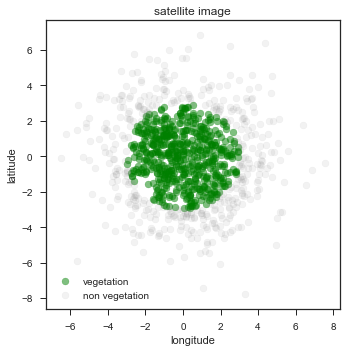

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x = data[:, :-1]
y = data[:, -1]
ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation', alpha=0.5)
ax.scatter(x[y == 0, 0], x[y == 0, 1], c='gray', label='non vegetation', alpha=0.1)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('satellite image')
ax.legend()
plt.tight_layout()
plt.show() 

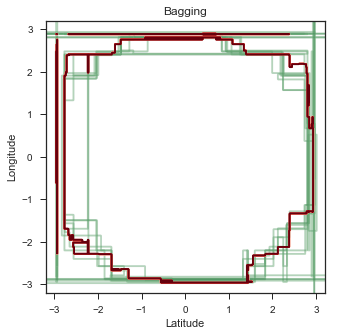

In [6]:
#Bagging
depth = None

fig, ax = plt.subplots(1, 1, figsize=(5, 5))


for i in range(8):
    sample_ind = np.random.choice(range(len(data)), len(data), replace=True)
    bootstrap = data[sample_ind]
    x = bootstrap[:, :-1]
    y = bootstrap[:, -1]
    ax = fit_and_plot_dt(x, y, depth, '', ax, plot_data=False, fill=False) 
    
bag = ensemble.BaggingClassifier(n_estimators=100)
bag.fit(x, y)

ax = plot_tree_boundary(x, y, bag, 'Bagging', ax, plot_data=False, fill=False, color='Reds', alpha=1.)

ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-3.2, 3.2)
plt.show() 

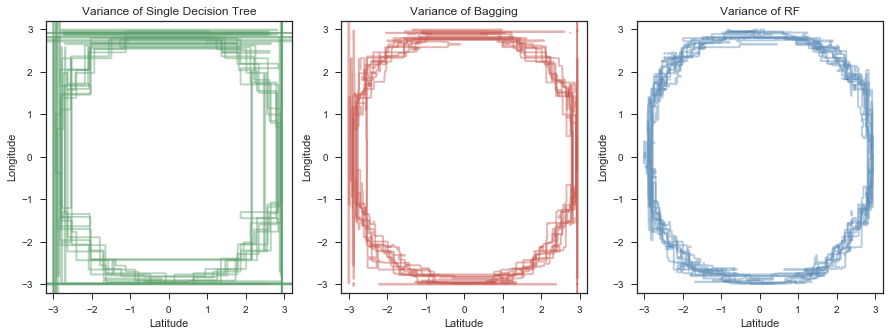

In [7]:
#Variance reduction: Baggining, RF, Tree
depth = None

fig, ax = plt.subplots(1, 3, figsize=(15, 5))


for i in range(8):
    new_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=1000)
    new_data = np.hstack((new_data, np.zeros((1000, 1))))
    new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2, 2] = 1
    x = new_data[:, :-1]
    y = new_data[:, -1]

    ax[0] = fit_and_plot_dt(x, y, depth, 'Variance of Single Decision Tree', ax[0], plot_data=False, fill=False)
    
    bag = ensemble.BaggingClassifier(n_estimators=30)
    bag.fit(x, y)
    ax[1] = plot_tree_boundary(x, y, bag, 'Variance of Bagging', ax[1], plot_data=False, fill=False, color='Reds')
    
    rf = ensemble.RandomForestClassifier(n_estimators=30)
    rf.fit(x, y)
    ax[2] = plot_tree_boundary(x, y, rf, 'Variance of RF', ax[2], plot_data=False, fill=False, color='Blues')


    
ax[0].set_xlim(-3.2, 3.2)
ax[0].set_ylim(-3.2, 3.2)
ax[1].set_xlim(-3.2, 3.2)
ax[1].set_ylim(-3.2, 3.2)
ax[2].set_xlim(-3.2, 3.2)
ax[2].set_ylim(-3.2, 3.2)
plt.show() 

In [8]:
#Errors
data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=200)
data = np.hstack((data, np.zeros((200, 1))))
data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(data[data[:, 0]**2 + data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x = data[:, :-1]
y = data[:, -1]

test_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=1000)
test_data = np.hstack((test_data, np.zeros((1000, 1))))
test_data[test_data[:, 0]**2 + test_data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(test_data[test_data[:, 0]**2 + test_data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

dt = tree.DecisionTreeClassifier()
dt.fit(x, y)
tree_score = np.array([dt.score(x_test, y_test)] * len(range(20, 320, 10)))

bag_score = []
bag_oob = []
rf_score = []
rf_oob = []
for i in range(20, 320, 10):
    bag = ensemble.BaggingClassifier(n_estimators=i, oob_score=True)
    bag.fit(x, y)
    bag_score.append(bag.score(x_test, y_test))

    bag_oob.append(bag.oob_score_)
    
    rf = ensemble.RandomForestClassifier(n_estimators=i, oob_score=True)
    rf.fit(x, y)
    rf_score.append(rf.score(x_test, y_test))
    rf_oob.append(rf.oob_score_)

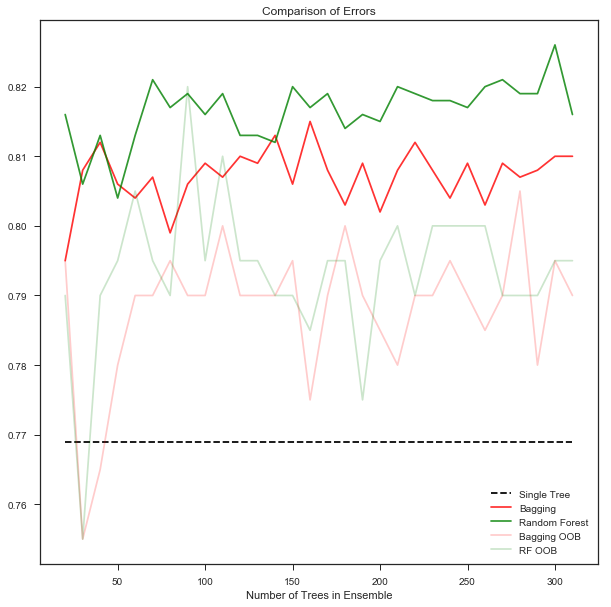

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
tree_score = np.array([dt.score(x_test, y_test)] * len(range(20, 320, 10)))
ax.plot(range(20, 320, 10), tree_score, color='black', linestyle='--', label='Single Tree')
ax.plot(range(20, 320, 10), bag_score, color='red', alpha=0.8, label='Bagging')
ax.plot(range(20, 320, 10), rf_score, color='green', alpha=0.8, label='Random Forest')
ax.plot(range(20, 320, 10), bag_oob, color='red', alpha=0.2, label='Bagging OOB')
ax.plot(range(20, 320, 10), rf_oob, color='green', alpha=0.2, label='RF OOB')
ax.set_title('Comparison of Errors')
ax.set_xlabel('Number of Trees in Ensemble')
ax.legend(loc='best')
plt.show()